## Initial Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import mean_squared_error
from doubleml import DoubleMLData, DoubleMLPLR
from sklearn.model_selection import KFold
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from sklearn.base import clone
import doubleml as dml
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Assigning the current directory to this_dir
from pathlib import Path
this_dir = Path (".")

# make it absolute
print(this_dir.resolve())


C:\Users\Anna\research_module\RM-project


## Data Creation

After implying the path to our data using *Path*, which ensuring better code readability and portability, we can start to read data files, correct them with the list of selected countries and make long format to make it more convinient for Machine Learning.

In [3]:
selected_countries = ["Belgium", "Austria", "Czechia", "Ireland", "Cyprus", "Hungary", "Serbia", "Switzerland", 
                       "Sweden", "Denmark", "France", "Spain", "Netherlands", "Germany", "Italy",
                       "Poland", "Lithuania", "Portugal", "Latvia", "Malta", 
                       "Slovenia", "Estonia", "Finland", "Croatia", "Greece"]
# Norway and Luxembourg were removed because of extreme outvalies of waste in 2015

We will start with the Policy dataset, where for countries that implemented a policy in a specific year, a value of 1 will be assigned from that year onwards. For years where no policy was applied, the value will be 0. These policies include laws that make it easier for migrants from non-EU countries to integrate. These laws are unique to each country and do not include EU-wide policies or referendums.

In [4]:
data_file_p = this_dir / "data" / "policy.xlsx"
data_file_p.resolve()
df_policy = pd.read_excel(data_file_p, sheet_name="Sheet1")

from help_func import convert_to_long_format
# Converting into long format
df_policy_long = convert_to_long_format(df_policy, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='Policy')

print(df_policy_long)

         Country  Year  Policy
0        Belgium  2014       0
1        Czechia  2014       0
2        Denmark  2014       0
3        Germany  2014       0
4        Estonia  2014       0
..           ...   ...     ...
238      Finland  2022       0
239       Sweden  2022       1
240       Norway  2022       1
241  Switzerland  2022       0
242       Serbia  2022       1

[243 rows x 3 columns]


Afterwards, we will move on to the data on municipal waste, which is measured in kilograms per capita. 

Municipal waste refers to waste generated by households, as well as small businesses and institutions, that is collected by or on behalf of municipalities. It typically includes waste from residential areas, street cleaning, and similar sources.

In [5]:
data_file_w = this_dir / "data" / "env_waste_mun.xlsx"
data_file_w.resolve()
data_was = pd.read_excel(data_file_w, sheet_name="Sheet 1")
data_was = data_was.rename(columns={"TIME": "Country"})

In [6]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')


filtered_data_was = data_was[data_was["Country"].isin(selected_countries)]

filtered_data_was = filtered_data_was.copy()
filtered_data_was['2018'] = filtered_data_was['2018'].astype(int)

filtered_data_was = filtered_data_was.drop(filtered_data_was.columns[1], axis=1)

from help_func import convert_to_long_format
# Converting into long format
filtered_data_was_long = convert_to_long_format(filtered_data_was, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='waste_per_cap')

print(filtered_data_was_long)

         Country  Year waste_per_cap
0        Belgium  2014           425
1        Czechia  2014           310
2        Denmark  2014           808
3        Germany  2014           631
4        Estonia  2014           357
..           ...   ...           ...
220     Slovenia  2022           487
221      Finland  2022           522
222       Sweden  2022           395
223  Switzerland  2022           677
224       Serbia  2022           473

[225 rows x 3 columns]


Lastly, we will perform the same manipulations with our covariates:

- Percentage of recent not EU migrants: This can affect levels of consumption and waste.
- Environmental tax in percent of GDP: Economic regulations can influence waste production.
- Unemployment in percent of labour force: Reflects the economic condition of a country.
- Real spending per capita: Consumer behavior is linked to the amount of waste generated.
- Urbanization rate: Urbanization usually leads to an increase in waste.

In [7]:
data_file_im = this_dir / "data" / "recent_noneu_per.xlsx"
data_file_im.resolve()
data_imm = pd.read_excel(data_file_im, sheet_name="Sheet 1")
data_imm = data_imm.rename(columns={"TIME": "Country"})

In [8]:
filtered_data_imm = data_imm[data_imm["Country"].isin(selected_countries)]
filtered_data_imm = filtered_data_imm.drop(filtered_data_imm.columns[-1], axis=1)

from help_func import convert_to_long_format
# Converting into long format
filtered_data_imm_long = convert_to_long_format(filtered_data_imm, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='nonEU_ratio')

print(filtered_data_imm_long)


         Country  Year nonEU_ratio
0        Belgium  2014         1.9
1        Czechia  2014         0.2
2        Denmark  2014         1.3
3        Germany  2014           1
4        Estonia  2014         0.2
..           ...   ...         ...
220     Slovenia  2022         1.7
221      Finland  2022         1.4
222       Sweden  2022         3.4
223  Switzerland  2022         2.3
224       Serbia  2022        0.15

[225 rows x 3 columns]


In [9]:
data_file_t = this_dir / "data" / "env_tax_gdp_per.xlsx"
data_file_t.resolve()
data_etax = pd.read_excel(data_file_t, sheet_name="Sheet 1")
data_etax = data_etax.rename(columns={"TIME": "Country"})

filtered_data_etax = data_etax[data_etax["Country"].isin(selected_countries)]


print(filtered_data_etax)

        Country  2014  2015  2016  2017  2018  2019  2020  2021  2022
1       Belgium  2.54  2.55  2.67  2.70  2.70  2.64  2.52  2.47  2.22
3       Czechia  2.12  2.05  2.10  2.01  1.96  2.04  1.92  1.84  1.48
4       Denmark     4  3.97  3.91  3.67  3.62  3.30  3.18  2.83  2.44
5       Germany  1.99  1.92  1.86  1.81  1.77  1.76  1.69  1.80  1.63
6       Estonia  2.66  2.73  2.97  2.86  2.73  3.18  2.40  2.32   2.3
7       Ireland   2.4  1.89  1.90  1.75  1.56  1.41  1.20  1.14  0.87
8        Greece   4.1  4.20  4.17  4.39  4.12  4.20  4.13  4.24   5.6
9         Spain  1.87  1.93  1.87  1.84  1.83  1.77  1.75  1.73  1.52
10       France  2.03  2.16  2.24  2.31  2.37  2.31  2.17  2.18  2.08
11      Croatia  3.96  4.21  4.31  4.33  4.36  4.24  4.07  3.86  3.34
12        Italy  3.57  3.39  3.51  3.34  3.31  3.24  3.06  3.01   2.2
13       Cyprus  3.06  3.03  2.91  2.97  2.83  2.52  2.35  2.26  2.19
14       Latvia  3.34  3.50  3.58  3.49  3.37  2.94  3.04  2.75  2.23
15    Lithuania  1.7

In [10]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_etax_long = convert_to_long_format(filtered_data_etax, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='env_tax')
print(filtered_data_etax_long)

         Country  Year env_tax
0        Belgium  2014    2.54
1        Czechia  2014    2.12
2        Denmark  2014       4
3        Germany  2014    1.99
4        Estonia  2014    2.66
..           ...   ...     ...
211     Portugal  2022    1.92
212     Slovenia  2022    2.87
213      Finland  2022    2.43
214       Sweden  2022    1.91
215  Switzerland  2022    1.27

[216 rows x 3 columns]


In [11]:
data_file_u = this_dir / "data" / "unemp_percent.xlsx"
data_file_u.resolve()
data_unemp = pd.read_excel(data_file_u, sheet_name="Sheet 1")
data_unemp = data_unemp.rename(columns={"TIME": "Country"})

filtered_data_unemp = data_unemp[data_unemp["Country"].isin(selected_countries)]
filtered_data_unemp = filtered_data_unemp.drop(filtered_data_unemp.columns[1:2], axis=1)
filtered_data_unemp = filtered_data_unemp.drop(filtered_data_unemp.columns[-1], axis=1)

print(filtered_data_unemp)

        Country  2015  2016  2017  2018  2019  2020  2021  2022
2       Belgium   8.7   7.9   7.2     6   5.5   5.8   6.3   5.6
4       Czechia   5.1     4   2.9   2.2     2   2.6   2.8   2.2
5       Denmark   6.3     6   5.8   5.1     5   5.6   5.1   4.5
6       Germany   4.4   3.9   3.6   3.2     3   3.7   3.7   3.2
7       Estonia   6.4   6.8   5.8   5.4   4.5   6.9   6.2   5.6
8       Ireland   9.9   8.4   6.7   5.8     5   5.9   6.2   4.5
9        Greece    25  23.9  21.8  19.7  17.9  17.6  14.7  12.5
10        Spain  22.1  19.6  17.2  15.3  14.1  15.5  14.9    13
11       France  10.3  10.1   9.4     9   8.4     8   7.9   7.3
12      Croatia  16.2    13  11.1   8.3   6.6   7.4   7.5   6.8
13        Italy    12  11.7  11.3  10.6   9.9   9.3   9.5   8.1
14       Cyprus    15    13  11.1   8.4   7.2   7.6   7.2   6.3
15       Latvia   9.9   9.7   8.7   7.4   6.3   8.1   7.6   6.9
16    Lithuania   9.1   7.9   7.1   6.2   6.3   8.5   7.1     6
18      Hungary   6.6     5     4   3.6 

In [12]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_unemp_long = convert_to_long_format(filtered_data_unemp, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='unemp_rate')


print(filtered_data_unemp_long)

         Country  Year unemp_rate
0        Belgium  2015        8.7
1        Czechia  2015        5.1
2        Denmark  2015        6.3
3        Germany  2015        4.4
4        Estonia  2015        6.4
..           ...   ...        ...
195     Slovenia  2022          4
196      Finland  2022        6.8
197       Sweden  2022        7.5
198  Switzerland  2022        4.1
199       Serbia  2022        9.6

[200 rows x 3 columns]


In [13]:
data_file_e = this_dir / "data" / "real_exp_pc.xlsx"
data_file_e.resolve()
data_exp = pd.read_excel(data_file_e, sheet_name="Sheet 1")
data_exp = data_exp.rename(columns={"TIME": "Country"})

filtered_data_exp = data_exp[data_exp["Country"].isin(selected_countries)]
filtered_data_exp = filtered_data_exp.drop(filtered_data_exp.columns[-1], axis=1)

print(filtered_data_exp)

        Country   2014   2015   2016   2017   2018   2019   2020   2021   2022
1       Belgium  21300  21700  21800  22300  23000  23600  22400  24400  26700
3       Czechia  14500  14800  15300  16300  16900  17600  16800  18200  19300
4       Denmark  21400  21800  21800  22700  23500  23700  23800  25600  25700
5       Germany  22500  22800  23500  24100  24800  25200  24400  25400  27400
6       Estonia  12700  13300  13700  14200  15000  15600  15400  16800  18200
7       Ireland  17300  17800  18300  18600  19200  19500  17600  19300  21900
8        Greece  14600  14600  14600  15200  15600  15800  14700  15900  18100
9         Spain  16200  16900  17200  18100  18400  18800  16500  18300  20000
10       France  20500  20800  21200  21500  21800  22500  21700  23200  24900
11      Croatia  11400  11600  12100  12700  13300  13900  13600  15500  17600
12        Italy  18200  18500  19000  19700  20100  20600  19100  20600  23200
13       Cyprus  16500  16900  17800  18600  19200  

In [14]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_exp_long = convert_to_long_format(filtered_data_exp, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='rexp_per_cap')

print(filtered_data_exp_long)

         Country  Year rexp_per_cap
0        Belgium  2014        21300
1        Czechia  2014        14500
2        Denmark  2014        21400
3        Germany  2014        22500
4        Estonia  2014        12700
..           ...   ...          ...
220     Slovenia  2022        20200
221      Finland  2022        25500
222       Sweden  2022        26000
223  Switzerland  2022        27300
224       Serbia  2022        12300

[225 rows x 3 columns]


In [15]:
data_file_ur = this_dir / "data" / "p_urbanization.xlsx"
data_file_ur.resolve()
data_urb = pd.read_excel(data_file_ur, sheet_name="Data")
data_urb = data_urb.rename(columns={"TIME": "Country"})

filtered_data_urb = data_urb[data_urb["Country"].isin(selected_countries)]

print(filtered_data_urb)

        Country    2014    2015    2016    2017    2018    2019    2020  \
0       Belgium  97.833  97.876  97.919  97.961  98.001  98.041  98.079   
1       Denmark  87.410  87.526  87.642  87.757  87.874  87.994  88.116   
2       Germany  77.190  77.200  77.224  77.261  77.312  77.376  77.453   
3       Estonia  68.269  68.416  68.563  68.717  68.880  69.051  69.229   
4        Sweden  86.247  86.553  86.852  87.146  87.431  87.708  87.977   
5         Spain  79.366  79.602  79.840  80.080  80.321  80.565  80.810   
6        France  79.394  79.655  79.917  80.180  80.444  80.709  80.975   
7         Italy  69.272  69.565  69.855  70.144  70.438  70.736  71.039   
8        Latvia  67.952  67.980  68.021  68.075  68.142  68.222  68.315   
9     Lithuania  67.108  67.230  67.366  67.516  67.679  67.855  68.046   
10        Malta  94.347  94.414  94.480  94.546  94.612  94.678  94.744   
12  Netherlands  89.690  90.173  90.635  91.077  91.490  91.876  92.236   
13      Austria  57.526  

In [16]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_urb_long = convert_to_long_format(filtered_data_urb, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='urb_ind')

print(filtered_data_urb_long)

         Country  Year  urb_ind
0        Belgium  2014   97.833
1        Denmark  2014   87.410
2        Germany  2014   77.190
3        Estonia  2014   68.269
4         Sweden  2014   86.247
..           ...   ...      ...
220       Cyprus  2022   66.911
221      Hungary  2022   72.552
222       Serbia  2022   56.873
223  Switzerland  2022   74.092
224       Greece  2022   80.357

[225 rows x 3 columns]


In [17]:
# Merging tables on the columns 'Country' and 'Year'
df_combined1 = pd.merge(filtered_data_was_long, df_policy_long,
                       on=['Country', 'Year'], how='inner')

# Adding other covariates in a similar way
df_combined2 = pd.merge(df_combined1, filtered_data_imm_long, on=['Country', 'Year'], how='inner')
df_combined3 = pd.merge(df_combined2, filtered_data_etax_long, on=['Country', 'Year'], how='inner')
df_combined4 = pd.merge(df_combined3, filtered_data_unemp_long, on=['Country', 'Year'], how='inner')
df_combined5 = pd.merge(df_combined4, filtered_data_exp_long, on=['Country', 'Year'], how='inner')
df = pd.merge(df_combined5, filtered_data_urb_long, on=['Country', 'Year'], how='inner')

df['waste_per_cap'] = pd.to_numeric(df['waste_per_cap'], errors='coerce')

print(df)


         Country  Year  waste_per_cap  Policy nonEU_ratio env_tax unemp_rate  \
0        Belgium  2015          412.0       0         1.5    2.55        8.7   
1        Czechia  2015          316.0       0         0.2    2.05        5.1   
2        Denmark  2015          822.0       0         1.5    3.97        6.3   
3        Germany  2015          632.0       0         1.3    1.92        4.4   
4        Estonia  2015          359.0       0         0.2    2.73        6.4   
..           ...   ...            ...     ...         ...     ...        ...   
187     Portugal  2022          508.0       1         1.5    1.92        6.2   
188     Slovenia  2022          487.0       1         1.7    2.87          4   
189      Finland  2022          522.0       0         1.4    2.43        6.8   
190       Sweden  2022          395.0       1         3.4    1.91        7.5   
191  Switzerland  2022          677.0       0         2.3    1.27        4.1   

    rexp_per_cap  urb_ind  
0          

## Data Analysis and Preprocessing

After setting the dataset with which I am planning to work we should build graphs and see if there a tendency in attitude to migration in policy of countries who were willing to sign the document and who - not. I am assuming that each country's decision is based on their general migration policy.

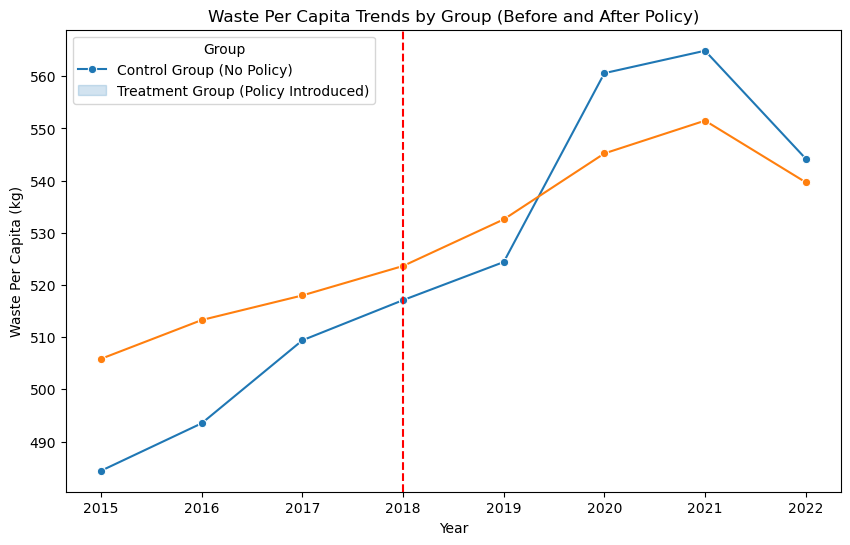

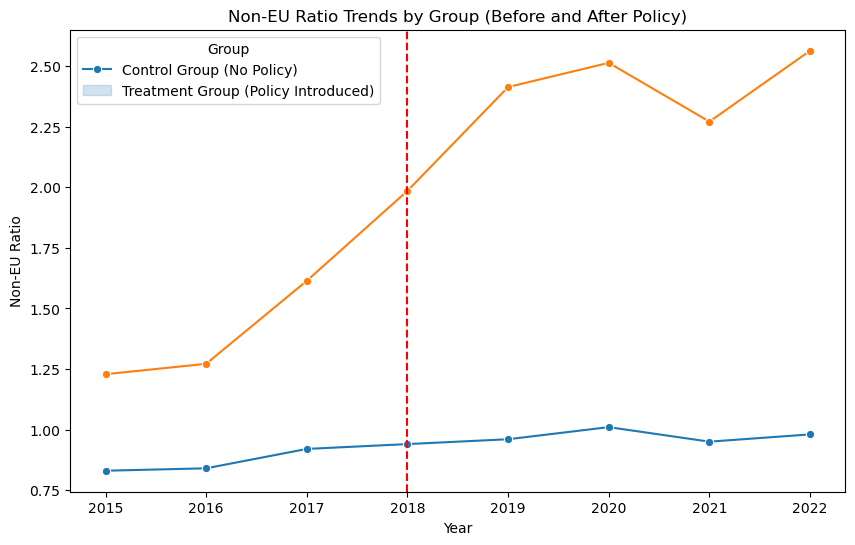

In [18]:

# Step 1: Groups by policy
countries_with_policy = df[df['Year'] > 2018].groupby('Country')['Policy'].max()
df['Group'] = df['Country'].map(lambda x: 1 if countries_with_policy[x] == 1 else 0)

# Step 2: Аggregation
avg_trends_waste = df.groupby(['Year', 'Group'])['waste_per_cap'].mean().reset_index()
avg_trends_nonEU = df.groupby(['Year', 'Group'])['nonEU_ratio'].mean().reset_index()

# Step 3:

# Graph 1: Waste Per Capita
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_trends_waste, x='Year', y='waste_per_cap', hue='Group', marker="o")
plt.axvline(2018, color='red', linestyle='--', label='Policy Introduced (2018)')
plt.title('Waste Per Capita Trends by Group (Before and After Policy)')
plt.ylabel('Waste Per Capita (kg)')
plt.xlabel('Year')
plt.legend(title='Group', labels=['Control Group (No Policy)', 'Treatment Group (Policy Introduced)'])
plt.show()

# Graph 2: Non-EU Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_trends_nonEU, x='Year', y='nonEU_ratio', hue='Group', marker="o")
plt.axvline(2018, color='red', linestyle='--', label='Policy Introduced (2018)')
plt.title('Non-EU Ratio Trends by Group (Before and After Policy)')
plt.ylabel('Non-EU Ratio')
plt.xlabel('Year')
plt.legend(title='Group', labels=['Control Group (No Policy)', 'Treatment Group (Policy Introduced)'])
plt.show()


In [19]:
# Standardization

# Select columns to be standardized
columns_to_scale = ['nonEU_ratio', 'env_tax', 'unemp_rate', 'rexp_per_cap', 'urb_ind']

# Keep non-standardized columns separately
other_columns = ['Country', 'Year', 'waste_per_cap', 'Policy']

# Standardize only the selected columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[columns_to_scale])

# Convert the standardized data back to a DataFrame
to_scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale, index=df.index)

# Combine standardized and non-standardized columns
scaled_df = pd.concat([df[other_columns], to_scaled_df], axis=1)
scaled_df['waste_per_cap'] = pd.to_numeric(scaled_df['waste_per_cap'], errors='coerce')

scaled_df


,Country,Year,waste_per_cap,Policy,nonEU_ratio,env_tax,unemp_rate,rexp_per_cap,urb_ind
0,Belgium,2015,412.0,0,-0.027648,-0.028069,0.307280,0.603199,1.980701
1,Czechia,2015,316.0,0,-0.849179,-0.650386,-0.575480,-1.141981,-0.071033
2,Denmark,2015,822.0,0,-0.027648,1.739310,-0.281227,0.628491,1.110360
3,Germany,2015,632.0,0,-0.154037,-0.812188,-0.747128,0.881416,0.242037
4,Estonia,2015,359.0,0,-0.849179,0.195965,-0.256706,-1.521368,-0.496617
...,...,...,...,...,...,...,...,...,...
187,Portugal,2022,508.0,1,-0.027648,-0.812188,-0.305748,0.223812,-0.583651
188,Slovenia,2022,487.0,1,0.098742,0.370213,-0.845213,0.223812,-1.561629
189,Finland,2022,522.0,0,-0.090842,-0.177425,-0.158621,1.564312,0.955212
190,Sweden,2022,395.0,1,1.173052,-0.824634,0.013027,1.690775,1.191592


In [20]:
data_dir = this_dir / "data"
output_file = data_dir / "panel_data.xlsx"
scaled_df.to_excel(output_file, index=False)

## DML Workflow

In [21]:
# DID principle
# Make a copy
df = scaled_df.copy()

# Step 1: calculate year difference waste_per_cap (2019 - 2017) for each country
diff_2019_2017 = df[(df['Year'] == 2019)][['Country', 'waste_per_cap']].copy()
diff_2017 = df[(df['Year'] == 2017)][['Country', 'waste_per_cap']].copy()

diff = diff_2019_2017.merge(diff_2017, on='Country', suffixes=('_2019', '_2017'))

diff['diff_waste_2019_2017'] = diff['waste_per_cap_2019'] - diff['waste_per_cap_2017']

# Step 2: Create D
control_countries = ['Czechia', 'Denmark', 'Italy', 'Latvia', 'Estonia', 'Finland', 'Hungary', 'Austria', 'Poland', 'Switzerland']
diff['D'] = diff['Country'].apply(lambda x: 0 if x in control_countries else 1)

# Steo 3: Add pretreatment covariates
covariates_2017 = df[df['Year'] == 2017][['Country', 'nonEU_ratio', 'env_tax', 'unemp_rate', 'rexp_per_cap', 'urb_ind']]  # Добавьте другие ковариаты, если нужно

data_ml_did = diff[['Country', 'diff_waste_2019_2017', 'D']].merge(covariates_2017, on='Country')
dummies = pd.get_dummies(data_ml_did['Country'], drop_first=True, dtype = int)
data_ml_did = pd.concat([data_ml_did, dummies], axis=1)

print(data_ml_did.head())

data_dir = this_dir / "data"
output_file = data_dir / "data_ml_did.xlsx"
data_ml_did.to_excel(output_file, index=False)


   Country  diff_waste_2019_2017  D  nonEU_ratio   env_tax  unemp_rate  \
0  Belgium                   5.0  1    -0.154037  0.158626   -0.060537   
1  Czechia                  11.0  0    -0.849179 -0.700171   -1.114945   
2  Denmark                  24.0  0     0.098742  1.365920   -0.403832   
3  Germany                 -18.0  1     0.667494 -0.949097   -0.943297   
4  Estonia                 -21.0  0    -0.659595  0.357767   -0.403832   

   rexp_per_cap   urb_ind  Belgium  Croatia  ...  Latvia  Lithuania  Malta  \
0      0.754954  1.987849        1        0  ...       0          0      0   
1     -0.762594 -0.054383        0        0  ...       0          0      0   
2      0.856124  1.129785        0        0  ...       0          0      0   
3      1.210218  0.247167        0        0  ...       0          0      0   
4     -1.293736 -0.471306        0        0  ...       0          0      0   

   Netherlands  Poland  Portugal  Slovenia  Spain  Sweden  Switzerland  
0            

In [23]:
ml_g = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=3)

ml_m = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=3)

np.random.seed(42)

# y is already defined as the difference of observed outcomes
obj_dml_data = dml.DoubleMLData(data_ml_did, 'diff_waste_2019_2017', 'D', x_cols = ['nonEU_ratio', 'env_tax', 'unemp_rate', 'rexp_per_cap', 'urb_ind'] + list(dummies.columns))

dml_did_obj = dml.DoubleMLDID(obj_dml_data, ml_g, ml_m)

print(dml_did_obj.fit())

================== DoubleMLDID Object ==================

------------------ Data summary      ------------------
Outcome variable: diff_waste_2019_2017
Treatment variable(s): ['D']
Covariates: ['nonEU_ratio', 'env_tax', 'unemp_rate', 'rexp_per_cap', 'urb_ind', 'Belgium', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Slovenia', 'Spain', 'Sweden', 'Switzerland']
Instrument variable(s): None
No. Observations: 24

------------------ Score & algorithm ------------------
Score function: observational

------------------ Machine learner   ------------------
Learner ml_g: RandomForestRegressor(max_depth=5, min_samples_leaf=3)
Learner ml_m: RandomForestClassifier(max_depth=5, min_samples_leaf=3)
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[19.93949717]]
Learner ml_g1 RMSE: [[17.56058151]]
Classification:
Learner ml_m Log Loss: [[

In [24]:
learner = LassoCV()

ml_l_sim = clone(learner)

ml_m_sim = clone(learner)

np.random.seed(3141)

obj_dml_plr_bonus = DoubleMLPLR(obj_dml_data, ml_l_sim, ml_m_sim)

obj_dml_plr_bonus.fit()

print(obj_dml_plr_bonus)

c:\Users\Anna\anaconda3\envs\res\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.632e-01, tolerance: 5.800e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Anna\anaconda3\envs\res\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.986e-01, tolerance: 5.800e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Anna\anaconda3\envs\res\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: diff_waste_2019_2017
Treatment variable(s): ['D']
Covariates: ['nonEU_ratio', 'env_tax', 'unemp_rate', 'rexp_per_cap', 'urb_ind', 'Belgium', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Slovenia', 'Spain', 'Sweden', 'Switzerland']
Instrument variable(s): None
No. Observations: 24

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: LassoCV()
Learner ml_m: LassoCV()
Out-of-sample Performance:
Regression:
Learner ml_l RMSE: [[21.5095501]]
Learner ml_m RMSE: [[0.56814134]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary   

## Additional features

In [25]:
# Making 'Country' as dummy-variable (one-hot encoding)
u_scaled_df = pd.get_dummies(scaled_df, columns=['Country'], drop_first=True, dtype=int)
u_scaled_df


,Year,waste_per_cap,Policy,nonEU_ratio,env_tax,unemp_rate,rexp_per_cap,urb_ind,Country_Belgium,Country_Croatia,...,Country_Latvia,Country_Lithuania,Country_Malta,Country_Netherlands,Country_Poland,Country_Portugal,Country_Slovenia,Country_Spain,Country_Sweden,Country_Switzerland
0,2015,412.0,0,-0.027648,-0.028069,0.307280,0.603199,1.980701,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2015,316.0,0,-0.849179,-0.650386,-0.575480,-1.141981,-0.071033,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015,822.0,0,-0.027648,1.739310,-0.281227,0.628491,1.110360,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2015,632.0,0,-0.154037,-0.812188,-0.747128,0.881416,0.242037,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2015,359.0,0,-0.849179,0.195965,-0.256706,-1.521368,-0.496617,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2022,508.0,1,-0.027648,-0.812188,-0.305748,0.223812,-0.583651,0,0,...,0,0,0,0,0,1,0,0,0,0
188,2022,487.0,1,0.098742,0.370213,-0.845213,0.223812,-1.561629,0,0,...,0,0,0,0,0,0,1,0,0,0
189,2022,522.0,0,-0.090842,-0.177425,-0.158621,1.564312,0.955212,0,0,...,0,0,0,0,0,0,0,0,0,0
190,2022,395.0,1,1.173052,-0.824634,0.013027,1.690775,1.191592,0,0,...,0,0,0,0,0,0,0,0,1,0


In [26]:
print(u_scaled_df.dtypes)

Year                     int64
waste_per_cap          float64
Policy                   int64
nonEU_ratio            float64
env_tax                float64
unemp_rate             float64
rexp_per_cap           float64
urb_ind                float64
Country_Belgium          int64
Country_Croatia          int64
Country_Cyprus           int64
Country_Czechia          int64
Country_Denmark          int64
Country_Estonia          int64
Country_Finland          int64
Country_France           int64
Country_Germany          int64
Country_Greece           int64
Country_Hungary          int64
Country_Ireland          int64
Country_Italy            int64
Country_Latvia           int64
Country_Lithuania        int64
Country_Malta            int64
Country_Netherlands      int64
Country_Poland           int64
Country_Portugal         int64
Country_Slovenia         int64
Country_Spain            int64
Country_Sweden           int64
Country_Switzerland      int64
dtype: object


In [27]:
data_dir = this_dir / "data"
output_file = data_dir / "panel_data_with_fixed_country.xlsx"
u_scaled_df.to_excel(output_file, index=False)